In [1]:
# formulas taken from https://www.tec-science.com/de/getriebe-technik/evolventenverzahnung/berechnung-von-zahnrader/

import numpy as np
from math import pi as π

from matplotlib import pyplot as plt
plt.style.use('dark_background')
from matplotlib import animation

input

In [2]:
# number of teeth (gear wheel size)
z1 = 24
z2 = 40

m  = 1   # module / mm (tooth size)
α0 = np.deg2rad(20)	 # normal pressure angle / rad (tooth shape)

# plot
Ninv  = 20   # points per involute
Ncirc = 200  # points per circle

functions

In [3]:
def plot_circ(*plt_args, radius = 1, center = (0,0), Npoints = 50, ax = None, **plt_kwargs ):
        """circle in x,y plane"""
        if ax is None:
            ax = plt.gca()
        # calculate circle coordinates
        angle = np.linspace(0, 2*np.pi, Npoints+1)
        x = center[0] + radius*np.cos(angle)
        y = center[1] + radius*np.sin(angle)
        # plot circle
        ax.plot( x, y, *plt_args, **plt_kwargs )
        ax.axis('equal')
        return ax


def inv(α):
    return np.tan(α) - α


def gear_contour(z,rb,rt):

    # involute
    αmax = np.arctan(np.sqrt((rt/rb)**2-1))
    α = np.linspace(0, αmax, Ninv)
    φ = inv(α)
    r = rb * np.sqrt(1 + (np.tan(α))**2)

    # tooth thickness
    φ0 = 2*π/z                           # tooth angle
    φb = φ0/2 + 2* inv(α0)               # tooth angle root
    φt = φ0/2 + 2*(inv(α0) - inv(αmax))  # tooth angle tip

    Narc = int(Ncirc/z/2)   # plot points per arc
    N    = 2*(Ninv+Narc)    # plot points per tooth
    
    angle  = np.zeros(N*z)
    radius = np.zeros(N*z)

    for n in range(z):
        
        # right flank
        angle [n*N : n*N+Ninv] = φ - φb/2 + n*φ0
        radius[n*N : n*N+Ninv] = r

        # tip circle
        angle [n*N+Ninv : n*N+Ninv+Narc] = np.linspace(-φt/2, φt/2, Narc+2)[1:-1] + n*φ0
        radius[n*N+Ninv : n*N+Ninv+Narc] = rt

        # left flank
        angle [n*N+Ninv+Narc : (n+1)*N-Narc] = (- φ + φb/2 + n*φ0)[::-1]
        radius[n*N+Ninv+Narc : (n+1)*N-Narc] = r[::-1]

        # base circle = root circle
        angle [(n+1)*N-Narc : (n+1)*N] = np.linspace(φb/2, φ0 - φb/2, Narc+2)[1:-1] + n*φ0
        radius[(n+1)*N-Narc : (n+1)*N] = rb

    return radius, angle


def gear_contour_cartesian(radius,angle,Ψ):
    x = radius*np.cos(angle + Ψ)
    y = radius*np.sin(angle + Ψ)
    vertices = np.vstack((x,y)).T
    return vertices

gear wheel dimensions

In [4]:
# axle distance
a = (z1+z2)*m/2

# reference radius (Teilkreis)
r01 = m*z1/2
r02 = m*z2/2

# base radius (Grundkreis)    
rb1 = r01 * np.cos(α0)
rb2 = r02 * np.cos(α0)

# tip radius (Kopfkreis) (s.t. base circle = root circle)
rt1 = a - rb2
rt2 = a - rb1
# rt1 = r01 + m
# rt2 = r02 + m

# initial gear rotation
Ψ10 = 0
Ψ20 = π/z2 * (z2 % 2 + 1)    # rotate one tooth for even number of teeth

# contour coordinates
radius1, angle1 = gear_contour(z1,rb1,rt1)
radius2, angle2 = gear_contour(z2,rb2,rt2)
vertices1 = gear_contour_cartesian(radius1,angle1,Ψ10)
vertices2 = gear_contour_cartesian(radius2,angle2,Ψ20)

initialise plot

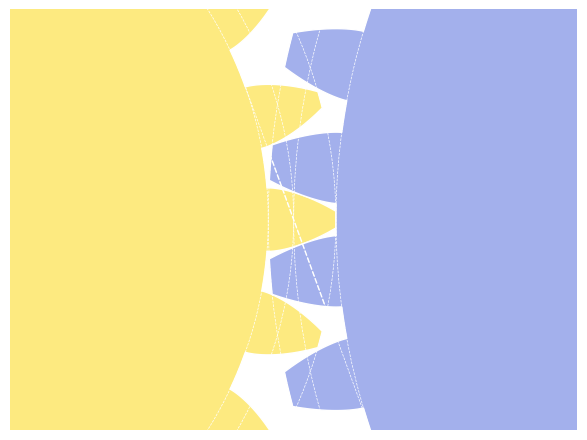

In [5]:
fig, ax = plt.subplots()
fig.tight_layout()
fig.patch.set_alpha(0.0)


# gear centers
ax.plot(0,0,'w+')
ax.plot(a,0,'w+')

# base circle = root circle (Grundkreis = Fußkreis)
plot_circ('w--', ax = ax, radius = rb1, center = (0,0), Npoints = Ncirc, linewidth=0.5)
plot_circ('w--', ax = ax, radius = rb2, center = (a,0), Npoints = Ncirc, linewidth=0.5)

# pitch circle = reference circle (Wälzkreis = Teilkreis)
plot_circ('w--', ax = ax, radius = r01, center = (0,0), Npoints = Ncirc, linewidth=0.5)
plot_circ('w--', ax = ax, radius = r02, center = (a,0), Npoints = Ncirc, linewidth=0.5)

# tip circle (Kopfkreis)
plot_circ('w--', ax = ax, radius = rt1, center = (0,0), Npoints = Ncirc, linewidth=0.5)
plot_circ('w--', ax = ax, radius = rt2, center = (a,0), Npoints = Ncirc, linewidth=0.5)

# line of action (Eingriffslinie)
xA =     rb1*np.cos(α0)
yA =     rb1*np.sin(α0)
xB = a - rb2*np.cos(α0)
yB =   - rb2*np.sin(α0)
ax.plot([xA,xB],[yA,yB], 'w--', linewidth=0.5)

# length of action (Eingriffsstrecke)
δ1  = np.arcsin(r01/rt1*np.sin(π/2+α0))
δ2  = np.arcsin(r02/rt2*np.sin(π/2+α0))
xE1 =     rt1*np.cos(π/2-α0-δ1)
yE1 =   - rt1*np.sin(π/2-α0-δ1)
xE2 = a - rt2*np.cos(π/2-α0-δ2)
yE2 =     rt2*np.sin(π/2-α0-δ2)
ax.plot([xE1,xE2],[yE1,yE2], 'w--', linewidth=1)


# gear 1
gear1 = plt.Polygon(vertices1, edgecolor='w', facecolor=(252/255,215/255,3/255,0.5), animated=True, antialiased=True)
ax.add_patch(gear1)

# gear 2
gear2 = plt.Polygon(vertices2 + [a,0], edgecolor='w', facecolor=(72/255,99/255,219/255,0.5), animated=True, antialiased=True)
ax.add_patch(gear2)


ax.axis('equal')
ax.set_xlim( r01/2,r01*1.5)
ax.set_ylim(-r01/2,r01/2  )
ax.set_axis_off()

animation

In [6]:
Nframes = 60

Ψ1 = Ψ10 - np.linspace(0, 2*π/z1, Nframes)
Ψ2 = Ψ20 + np.linspace(0, 2*π/z2, Nframes)

def animate(i):
    vertices1 = gear_contour_cartesian(radius1,angle1,Ψ1[i])
    vertices2 = gear_contour_cartesian(radius2,angle2,Ψ2[i])
    gear1.set_xy(vertices1)
    gear2.set_xy(vertices2 + [a,0])
    return gear1, gear2,

ani = animation.FuncAnimation(
    fig, animate, interval=2, blit=True, save_count=Nframes-1)

save to gif

In [7]:
ani.save(
    "involute_gears.gif",
    codec="png",
    dpi=200,
    fps=30,
    bitrate=-1,
    savefig_kwargs={"transparent": True, "facecolor": "none"},
)